# Main Results 2b

In [50]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pandas import read_csv
from tqdm import tqdm
sns.set_style('white')
sns.set_context('notebook', font_scale=1.33)
%matplotlib inline

## Section 1: Internal Consistency

#### 1.1 Load and prepare data

In [51]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define subscales.
subscales = {
    '7u':    ['7u7d-q01','7u7d-q03','7u7d-q04','7u7d-q06','7u7d-q07','7u7d-q08','7u7d-q13'],
    '7d':    ['7u7d-q02','7u7d-q05','7u7d-q09','7u7d-q10','7u7d-q11','7u7d-q12','7u7d-q14'],
    'gad7':  ['gad7-q01','gad7-q02','gad7-q03','gad7-q04','gad7-q05','gad7-q06','gad7-q07'],
    'pswq':  ['pswq-q01','pswq-q02','pswq-q03'],
    'bis':   ['bisbas-q01','bisbas-q02','bisbas-q03','bisbas-q04'],
    'bas':   ['bisbas-q05','bisbas-q06','bisbas-q07','bisbas-q08',
              'bisbas-q09','bisbas-q10','bisbas-q11','bisbas-q12'],
    'shaps': ['shaps-q01','shaps-q02','shaps-q03','shaps-q04','shaps-q05',
              'shaps-q06','shaps-q07','shaps-q08','shaps-q09','shaps-q10',
              'shaps-q11','shaps-q12','shaps-q13','shaps-q14'],
}

## Define max response option per scale (0-indexed).
scale_max = [3,3,3,3,3,3]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load reject data.
reject = read_csv(os.path.join('data','reject.csv'))

## Load survey data.
surveys = read_csv(os.path.join('data','surveys.csv'))

## Restrict participants.
surveys = surveys.loc[surveys.subject.isin(reject.subject)]

## Iteratively compute sum scores.
for i, (k, v) in enumerate(subscales.items()):
    surveys[k] = surveys[v].sum(axis=1)
    
## Merge infrequency items.
surveys = surveys.merge(reject[['platform','subject','infreq']])
surveys['infreq'] = np.where(surveys['infreq'], 1, 0)

## Restrict survey to valid items.
items = surveys[['platform','subject','infreq']+np.concatenate([*subscales.values()]).tolist()]

## Melt DataFrame.
scores = surveys[['platform','subject','infreq']+list(subscales.keys())]

#### 1.2 Permutation Testing

In [3]:
from scipy.stats import ttest_1samp

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define number of permutations.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Define items of interest.
cols = items.filter(regex='-q').columns

## Compute average difference of interitem correlations across subscales.
iic = []
for ss in list(subscales.keys()):
            
    ## Compute correlation matrices.
    A = items.loc[items.infreq==0,subscales[ss]].corr(method='spearman')
    B = items.loc[items.infreq==1,subscales[ss]].corr(method='spearman')
    D = (A - B).values
    
    ## Store correlations.
    iic = np.append(iic, D[np.tril_indices_from(D, k=-1)])
    
## Compute average and t-statistic.
mu_iic = np.mean(iic)
tval, _ = ttest_1samp(iic, popmean=0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space
null_tvals = np.zeros(n_iter)

## Main loop.
permuted = items.copy()
for n in tqdm(range(n_iter)):
    
    ## Permute rows of infrequncy score.
    permuted.infreq = np.random.permutation(permuted.infreq)
    
    iic = []
    for ss in list(subscales.keys()):

        ## Compute correlation matrices.
        A = permuted.loc[permuted.infreq==0,subscales[ss]].corr(method='spearman')
        B = permuted.loc[permuted.infreq==1,subscales[ss]].corr(method='spearman')
        D = (A - B).values

        ## Store correlations.
        iic = np.append(iic, D[np.tril_indices_from(D, k=-1)])
        
    ## Compute and store t-statistic.
    null_tvals[n], _ = ttest_1samp(iic, popmean=0)
    
## Compute p-value.
pval = (np.abs(tval) <= np.abs(null_tvals)).sum() / (n_iter + 1)

100%|██████████| 5000/5000 [08:42<00:00,  9.57it/s]


In [4]:
## Report statistic.
print('mean: %0.3f' %mu_iic)
print('tval: %0.3f' %tval)
print('pval: %0.3f' %pval)

mean: 0.138
tval: 16.822
pval: 0.000


#### 1.3 Plotting

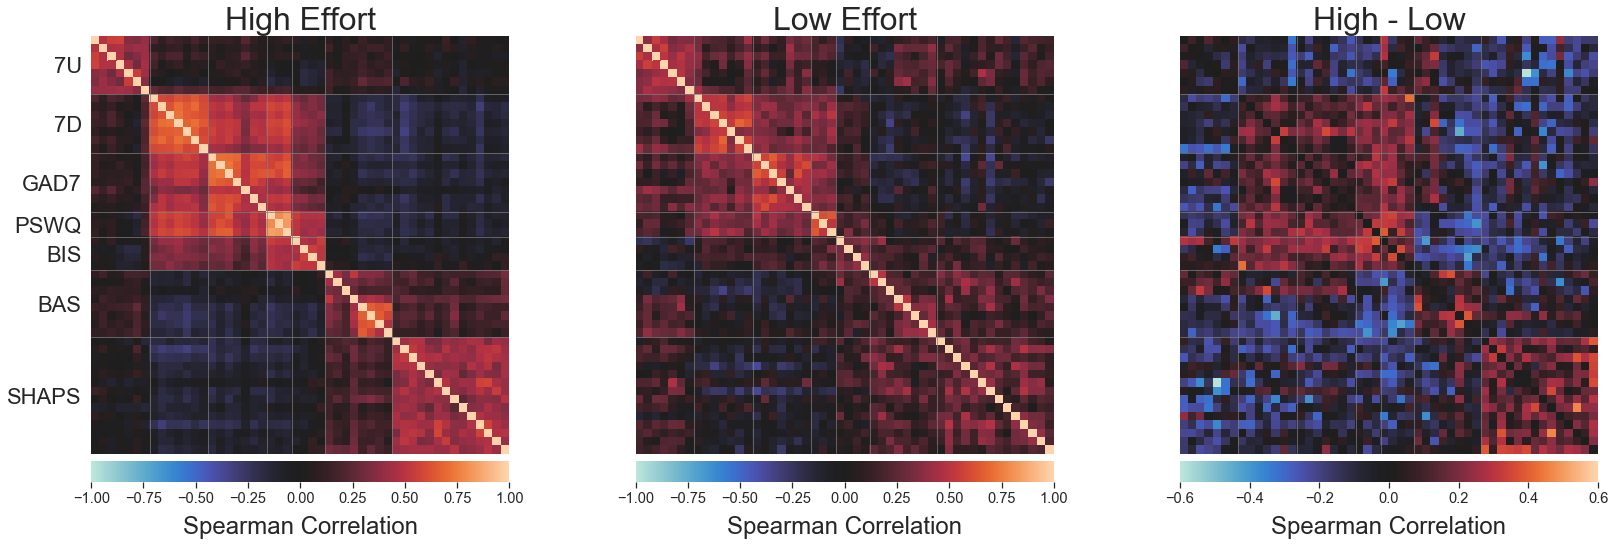

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(24,8))
cols = np.concatenate([v for v in subscales.values()])
labels = ['7U','7D','GAD7','PSWQ','BIS','BAS','SHAPS']
titles = ['High Effort', 'Low Effort', 'High - Low']

## Compute correlation matrices.
A = items.query('infreq==0')[cols].corr(method='spearman')
B = items.query('infreq==1')[cols].corr(method='spearman')
D = (A - B).values

## Iteratively plot.
for n, (ax, corr, v, title) in enumerate(zip(axes, [A,B,D], [1.0,1.0,0.6], titles)):

    ## Make space for colorbar.
    divider = make_axes_locatable(ax)
    cbar_ax = divider.append_axes("bottom", size="5%", pad=0.1)
    
    ## Plot correlation matrix.
    sns.heatmap(corr, center=0, vmin=-v, vmax=v, cbar=True, square=True, 
                xticklabels=[], yticklabels=[], ax=ax, cbar_ax=cbar_ax, 
                cbar_kws=dict(orientation="horizontal"))
    
    ## Update colorbar.
    cbar = ax.collections[0].colorbar
    cbar.set_label('Spearman Correlation', fontsize=24, labelpad=10)
    
    ## Add grid lines.
    cumsum = np.cumsum([len(v) for v in subscales.values()])
    for i in cumsum: 
        ax.axhline(i, color='0.5', lw=0.7)
        ax.axvline(i, color='0.5', lw=0.7)
        
    ## Add labels.
    yticks = [3.5,10.5,17.5,22.5,26,32,43]
    ax.set_title(title, fontsize=32)
    if not n: ax.set_yticks(yticks)
    if not n: ax.set_yticklabels(labels, fontsize=22)
        
## Save figure.
f = os.path.join('..','figures','main_02b.png')
plt.subplots_adjust(top=0.90, left=0.05, right=0.98, wspace=0.05)
plt.savefig(f, dpi=300)

## Section 2: Rates of Clinical Endorsement 

In [56]:
## Iteratively compute sum scores.
for i, (k, v) in enumerate(subscales.items()):
    if k == 'shaps': surveys[v] = np.where(surveys[v] < 2, 1, 0)
    surveys[k] = surveys[v].sum(axis=1)
    
## Restrict survey to valid items.
items = surveys[['platform','subject','infreq']+np.concatenate([*subscales.values()]).tolist()]

## Melt DataFrame.
scores = surveys[['platform','subject','infreq']+list(subscales.keys())]

metadata = read_csv('data/metadata.csv')
scores = scores.merge(metadata[['platform','subject','gender-categorical']])

#### 2.1 Mania / Depression

In [61]:
scores.groupby('infreq')[['7u','7d']].mean().round(2)

,7u,7d
infreq,,
0,3.87,4.75
1,10.15,10.68


In [36]:
print('Mania (Cutoff=12)')
print('Pre:  %0.3f' %(scores['7u'] >= 12).mean())
print('Post: %0.3f' %(scores.query('infreq==0')['7u'] >= 12).mean())

Mania (Cutoff=12)
Pre:  0.130
Post: 0.040


In [35]:
print('Depression (Cutoff=12)')
print('Pre:  %0.3f' %(scores['7d'] >= 12).mean())
print('Post: %0.3f' %(scores.query('infreq==0')['7d'] >= 12).mean())

Depression (Cutoff=12)
Pre:  0.174
Post: 0.093


#### 2.2 Anxiety

In [62]:
scores.groupby('infreq').gad7.mean().round(2)

infreq
0    4.86
1    9.73
Name: gad7, dtype: float64

In [38]:
print('Mania (Cutoff=10)')
print('Pre:  %0.3f' %(scores['gad7'] >= 10).mean())
print('Post: %0.3f' %(scores.query('infreq==0')['gad7'] >= 10).mean())

Mania (Cutoff=10)
Pre:  0.259
Post: 0.173


#### 2.3 Anhedonia

In [66]:
scores.groupby('infreq').shaps.mean().round(2)

infreq
0    0.87
1    1.79
Name: shaps, dtype: float64

In [65]:
print('Anhedonia (Cutoff=3)')
print('Pre:  %0.3f' %(scores['shaps'] >= 3).mean())
print('Post: %0.3f' %(scores.query('infreq==0')['shaps'] >= 3).mean())

Anhedonia (Cutoff=3)
Pre:  0.179
Post: 0.146


#### 2.4 BIS

In [80]:
from scipy.stats import ttest_ind

print(ttest_ind(
    scores.loc[(scores['gender-categorical']=='Female')&(scores['infreq']==0),'bis'].values,
    scores.loc[(scores['gender-categorical']=='Male')&(scores['infreq']==0),'bis'].values
))

print(ttest_ind(
    scores.loc[(scores['gender-categorical']=='Female')&(scores['infreq']==1),'bis'].values,
    scores.loc[(scores['gender-categorical']=='Male')&(scores['infreq']==1),'bis'].values
))

scores.groupby(['infreq','gender-categorical']).bis.mean()

Ttest_indResult(statistic=5.730043825287055, pvalue=2.4562386021500025e-08)
Ttest_indResult(statistic=0.2079837387431376, pvalue=0.8357637245918252)


infreq  gender-categorical
0       Female                 9.081761
        Male                   7.312057
        Other                 12.000000
1       Female                 8.083333
        Male                   7.978723
        Other                 10.500000
Name: bis, dtype: float64